In [1]:
import os
import time
import torch
import random
import argparse

import numpy as np
import torchvision
from tqdm import tqdm
from glob import glob

import torch.nn.functional as F
from collections import OrderedDict

from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel 
from transformers import CLIPTokenizer, CLIPTextModel

from vae import VAE
from unet_cond import Unet
from linear_noise_scheduler import LinearNoiseScheduler

import pose
import class_consistent
import loader
import resampling

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
elif torch.xpu.is_available():
    import intel_extension_for_pytorch as ipex
    device = torch.device("xpu")
    print("XPU is available. Using XPU.")
else:
    device = torch.device("cpu")
    print("CUDA and XPU are not available. Using CPU.")

CUDA is available. Using GPU.


In [5]:

Imgweights = [0.700] # we use these weights [0.850, 0.700, 0.550, 0.250, 0.950, 0.400]
# dir_path = os.path.dirname(__file__)
Diff_model = './models' 
VAE_model = './models' 
dataset_name = 'MTF_generation' # the folder of saving the generated result
Image_size = 128
batch_size = 1
time_steps = 500 
num_steps = time_steps  # put the same value for the time_steps and num_steps

MTF_Image_data_dir = "Data/test/image/"
MTF_Text_data_dir = "Data/test/prompt/"
# dir_path = Data_dir
print('Data path: ', MTF_Text_data_dir)
text_weight = 0

clip_model_name = "openai/clip-vit-large-patch14"
tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)
processor = CLIPProcessor.from_pretrained(clip_model_name)

textencoder = CLIPTextModel.from_pretrained(clip_model_name).to(device) 
clip_model = CLIPModel.from_pretrained(clip_model_name, output_hidden_states=True).to(device) 

for param in clip_model.parameters():
    param.requires_grad = False
for param in textencoder.parameters():
    param.requires_grad = False

print("--CLIP models loaded successfully!--")

vae = VAE(im_channels=3).to(device)  
# vae = vae.float()
model = Unet(im_channels=4).to(device)

scheduler = LinearNoiseScheduler(num_timesteps=time_steps, 
                            beta_start=1e-4,
                            beta_end=0.02, 
                            ldm_scheduler=True)

# Load the pre-traiened the VAE model
if os.path.exists(os.path.join(VAE_model,'vae_autoencoder.pth')):        
    vae.load_state_dict(torch.load(os.path.join(VAE_model, 'vae_autoencoder.pth'), map_location=device))
    vae.eval()                   
    vae.float()                  
    for param in vae.parameters():
        param.requires_grad = False                
    print('--VAE loaded successfully--')
else:
    print("There is no checkpoint of vae loaded")

# Model 500 steps based
if os.path.exists(os.path.join(Diff_model, 'ddpm_500_Light.pth')):
    checkpoint = torch.load(os.path.join(Diff_model, 'ddpm_500_Light.pth'), map_location='cpu')
    state_dict = checkpoint['model_state_dict']

    # Remove 'module.' prefix if needed
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")  # for remove 'module.' prefix
        new_state_dict[new_key] = v

    model.load_state_dict(new_state_dict)
    print("--Diffusion model loaded successfully--")
else:
    print("There is no checkpoint of diffusion model loaded")     

Data path:  Data/test/prompt/
--CLIP models loaded successfully!--
--VAE loaded successfully--
--Diffusion model loaded successfully--


k-blending: 4, text_weight: 0.7, image_weight: 0.30
Generated images will save at: MTF_generation
Total samples of images: 1252, Text samples: 1252
image_path:  ['Data/test/image\\Aamir Khan_0.jpg']
text_path:  ['Data/test/prompt\\Aamir Khan_0.txt']
test_dataset:  1252
--Class pool of images preparation--
--Poses calculation--


Denoising steps:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [00:21<00:00, 22.86it/s]

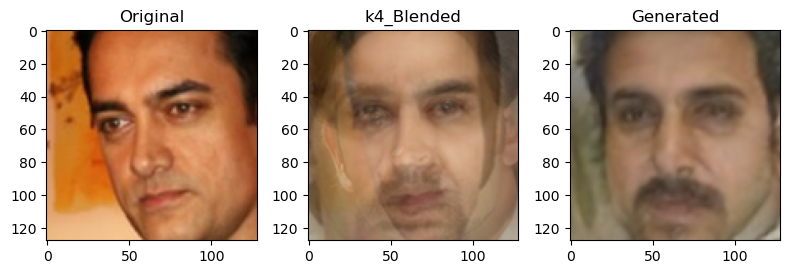

Denoising steps::  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 497/500 [00:21<00:00, 22.78it/s]

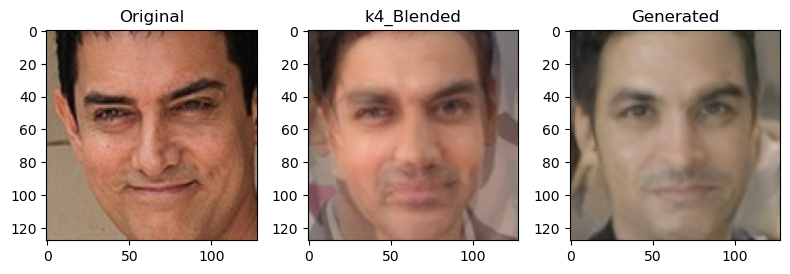

Denoising steps::  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 497/500 [00:20<00:00, 24.18it/s]

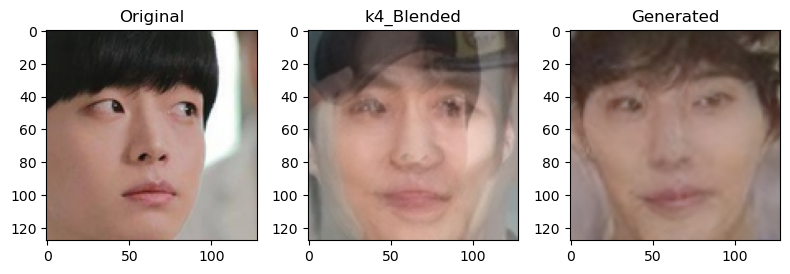

Denoising steps::  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 497/500 [00:20<00:00, 23.99it/s]

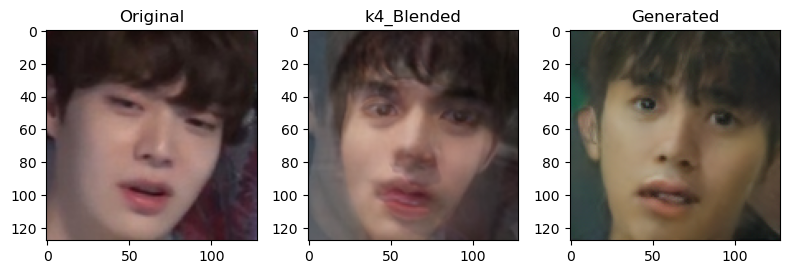

Denoising steps::  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 497/500 [00:20<00:00, 23.95it/s]

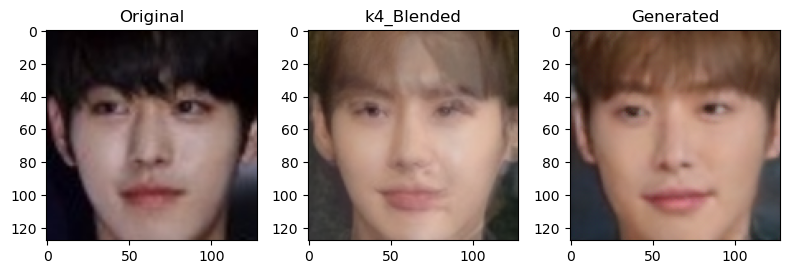

KeyboardInterrupt: 

In [ ]:
for imgw in Imgweights:
    # k indicate the number of images you want to blend along with the original (target) image, it can be between 1 and 5.
    for k in range(3, 4):
        k_blending = k # The value of blending or class-based factor that can blen along with the target image (2-images, 3-images, 4-images, etc.)        
        text_weight = imgw
        image_weight = 1.0 - text_weight 
        print(f'k-blending: {k_blending + 1}, text_weight: {imgw}, image_weight: {image_weight:0.2f}') # Blended image equal k + 1, since they` uniformly averaged along with the traget image.
        print('Generated images will save at:', dataset_name)
        
        # Path of save Testing 
        Save_monitoring_path = os.path.join(dataset_name, f"GeneratedImg_{time_steps}_steps/K{k_blending}/ImgW_{np.round(image_weight,3)}")
    
        if not os.path.exists(Save_monitoring_path):
            if not os.path.exists(dataset_name):
                os.makedirs(dataset_name, exist_ok=True)
            os.makedirs(Save_monitoring_path, exist_ok=True)
        image_path = sorted(glob(os.path.join(MTF_Image_data_dir, '*.*')))
        text_path = sorted(glob(os.path.join(MTF_Text_data_dir, '*.*')))

        image_path = sorted(list(image_path))
        text_path = sorted(list(text_path))

        print(f"Total samples of images: {len(image_path)}, Text samples: {len(text_path)}")
        N_train = len(image_path)
        print('image_path: ', image_path[:1])
        print('text_path: ',text_path[:1])

        # Load dataset
        test_dataset, tokenizer, textencoder = loader.load_and_transform_dataset(Image_size, image_path, text_path, tokenizer, textencoder, use_augmentation=False)
        print('test_dataset: ', len(test_dataset))  # Check the number of images
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, pin_memory=True)
    
        with torch.no_grad():
            resampling.img_generation(model, scheduler, vae, test_dataloader, Image_size, k_blending, device, tokenizer, textencoder, processor, clip_model, time_steps, image_weight, dataset_name, Save_monitoring_path, text_weight)